# Time-series Forecasting

## Description
The data consists of 52,416 observations of energy consumption on a 10-minute window. Every observation is described by the following feature columns.

Your task is to **aggregate the observations on an interval of 1 hour**. For this time interval, using the values of the **6 previous time intervals**, forecast the target value one step in the future. Choose which features you are going to use.

**You must train an LSTM network.**



Features:

* TimePeriod: Time window of ten minutes.
* WT: Weather Temperature.
* WH: Weather Humidity.
* WS: Wind Speed.
* GDF: General Diffuse Flow. “Diffuse flow” is a catchall term to describe low-temperature (< 0.2° to ~ 100°C) fluids that slowly discharge through sulfide mounds, fractured lava flows, and assemblages of bacterial mats and macrofauna.
* DF: DiffuseFlows

Target:

Consumption

## Dateset links:
 * [DS1](https://drive.google.com/file/d/1-8neeIpiq6yzWVw4EG_WgzHX4kPH1n1j/view?usp=sharing)
 * [DS2](https://drive.google.com/file/d/1-LhrUaH59q8O0SYB8WE-Eov2gaTMQYVx/view?usp=sharing)

In [106]:
!gdown 1-8neeIpiq6yzWVw4EG_WgzHX4kPH1n1j

Downloading...
From: https://drive.google.com/uc?id=1-8neeIpiq6yzWVw4EG_WgzHX4kPH1n1j
To: /content/power_consumption_g2_feat.csv
100% 2.55M/2.55M [00:00<00:00, 174MB/s]


In [107]:
!gdown 1-LhrUaH59q8O0SYB8WE-Eov2gaTMQYVx

Downloading...
From: https://drive.google.com/uc?id=1-LhrUaH59q8O0SYB8WE-Eov2gaTMQYVx
To: /content/power_consumption_g2.csv
100% 1.67M/1.67M [00:00<00:00, 117MB/s]


In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [109]:
pd.set_option('display.max_columns', None)

In [110]:
data1 = pd.read_csv('/content/power_consumption_g2_feat.csv')

In [111]:
data2 = pd.read_csv('/content/power_consumption_g2.csv')

In [112]:
data1.head(3)

,TimePeriod,WT,WH,WS,GDF,DF
0,2017-03-01 16:40:00,21.33,55.91,0.080,387.400,427.300
1,2017-07-27 06:30:00,23.10,48.58,4.908,10.450,8.630
2,2017-10-11 19:00:00,23.10,59.82,0.084,0.446,0.322


In [113]:
data2.head(3)

,TimePeriod,Consumption
0,2017-12-02 20:10:00,36824.33460
1,2017-12-25 15:30:00,31841.82510
2,2017-05-19 21:10:00,44909.11475


In [114]:
data1.isna().sum()

TimePeriod      0
WT            559
WH            499
WS            529
GDF           524
DF            505
dtype: int64

In [115]:
data2.isna().sum()

TimePeriod     0
Consumption    0
dtype: int64

<ipython-input-116-f92a39913c56>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data1.corr(), annot=True)


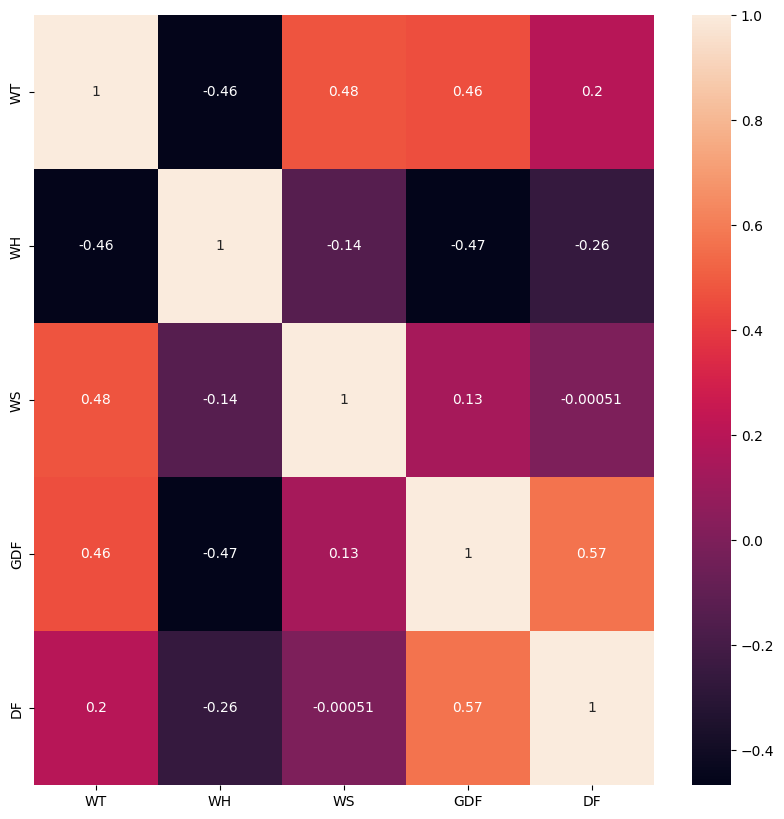

In [116]:
plt.figure(figsize=(10, 10))
sns.heatmap(data1.corr(), annot=True)
plt.show()

In [117]:
data1['TimePeriod'] = pd.to_datetime(data1['TimePeriod'])
data1 = data1.set_index('TimePeriod')
data1 = data1.sort_index()
data1.head(5)

,WT,WH,WS,GDF,DF
TimePeriod,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085


In [118]:
data2['TimePeriod'] = pd.to_datetime(data2['TimePeriod'])
data2 = data2.set_index('TimePeriod')
data2 = data2.sort_index()
data2.head(5)

,Consumption
TimePeriod,
2017-01-01 00:00:00,34055.69620
2017-01-01 00:10:00,29814.68354
2017-01-01 00:20:00,29128.10127
2017-01-01 00:30:00,28228.86076
2017-01-01 00:40:00,27335.69620


In [119]:
to_fill_columns = data1.columns

In [120]:
imputer = IterativeImputer()
data1[to_fill_columns] = imputer.fit_transform(data1[to_fill_columns])

In [121]:
data1.isna().sum()

WT     0
WH     0
WS     0
GDF    0
DF     0
dtype: int64

In [122]:
data = data1.merge(data2, how='left', left_index=True, right_index=True)

In [123]:
data

,WT,WH,WS,GDF,DF,Consumption
TimePeriod,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051000,0.119,34055.69620
2017-01-01 00:10:00,6.414,74.5,0.083,0.070000,0.085,29814.68354
2017-01-01 00:20:00,6.313,74.5,0.080,0.062000,0.100,29128.10127
2017-01-01 00:30:00,6.121,75.0,0.083,0.091000,0.096,28228.86076
2017-01-01 00:40:00,5.921,75.7,0.081,0.048000,0.085,27335.69620
...,...,...,...,...,...,...
2017-12-30 23:10:00,7.010,72.4,0.080,-51.067405,0.096,31160.45627
2017-12-30 23:20:00,6.947,72.6,0.082,0.051000,0.093,30430.41825
2017-12-30 23:30:00,6.900,72.8,0.086,0.084000,0.074,29590.87452


In [124]:
data = data.groupby(pd.Grouper(freq='60min')).mean()

In [125]:
data

,WT,WH,WS,GDF,DF,Consumption
TimePeriod,,,,,,
2017-01-01 00:00:00,7.719129,75.066667,0.081833,0.063500,0.098833,29197.974683
2017-01-01 01:00:00,5.548833,78.439839,0.082000,0.056833,0.112500,24657.215190
2017-01-01 02:00:00,5.054333,78.933333,0.082333,0.063000,0.129167,22083.037973
2017-01-01 03:00:00,5.004333,77.083333,0.082833,0.059833,0.141000,20811.139240
2017-01-01 04:00:00,5.097667,74.050000,0.082333,0.058000,0.122833,20475.949367
...,...,...,...,...,...,...
2017-12-30 19:00:00,9.453333,65.341847,0.074667,0.052000,0.102000,37513.814957
2017-12-30 20:00:00,9.041667,63.990000,0.080333,0.052667,0.105000,37008.871988
2017-12-30 21:00:00,8.011667,69.675000,0.081500,0.073167,0.098333,35358.174905


In [126]:
columns = data.columns

In [127]:
lag = 6

for i in range(1, lag+1):
  for col in columns:
    data[f'{col}_prev_{i}'] = data[f'{col}'].shift(i)

In [128]:
data.isna().sum()

WT                    0
WH                    0
WS                    0
GDF                   0
DF                    0
Consumption           0
WT_prev_1             1
WH_prev_1             1
WS_prev_1             1
GDF_prev_1            1
DF_prev_1             1
Consumption_prev_1    1
WT_prev_2             2
WH_prev_2             2
WS_prev_2             2
GDF_prev_2            2
DF_prev_2             2
Consumption_prev_2    2
WT_prev_3             3
WH_prev_3             3
WS_prev_3             3
GDF_prev_3            3
DF_prev_3             3
Consumption_prev_3    3
WT_prev_4             4
WH_prev_4             4
WS_prev_4             4
GDF_prev_4            4
DF_prev_4             4
Consumption_prev_4    4
WT_prev_5             5
WH_prev_5             5
WS_prev_5             5
GDF_prev_5            5
DF_prev_5             5
Consumption_prev_5    5
WT_prev_6             6
WH_prev_6             6
WS_prev_6             6
GDF_prev_6            6
DF_prev_6             6
Consumption_prev

In [129]:
data = data.dropna(axis=0)

In [130]:
data.columns

Index(['WT', 'WH', 'WS', 'GDF', 'DF', 'Consumption', 'WT_prev_1', 'WH_prev_1',
       'WS_prev_1', 'GDF_prev_1', 'DF_prev_1', 'Consumption_prev_1',
       'WT_prev_2', 'WH_prev_2', 'WS_prev_2', 'GDF_prev_2', 'DF_prev_2',
       'Consumption_prev_2', 'WT_prev_3', 'WH_prev_3', 'WS_prev_3',
       'GDF_prev_3', 'DF_prev_3', 'Consumption_prev_3', 'WT_prev_4',
       'WH_prev_4', 'WS_prev_4', 'GDF_prev_4', 'DF_prev_4',
       'Consumption_prev_4', 'WT_prev_5', 'WH_prev_5', 'WS_prev_5',
       'GDF_prev_5', 'DF_prev_5', 'Consumption_prev_5', 'WT_prev_6',
       'WH_prev_6', 'WS_prev_6', 'GDF_prev_6', 'DF_prev_6',
       'Consumption_prev_6'],
      dtype='object')

In [131]:
features = data.drop(columns=['WT', 'WH', 'WS', 'GDF', 'DF', 'Consumption'])

In [132]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [133]:
X, Y = features, data['Consumption']

In [134]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

In [135]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
Y_train = scaler.fit_transform(Y_train.values.reshape(-1, 1))

In [136]:
X_train.shape

(6984, 36)

In [137]:
X_train = X_train.reshape(X_train.shape[0], lag, X_train.shape[1] // lag)
X_test = X_test.reshape(X_test.shape[0], lag, X_test.shape[1] // lag)

In [138]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import keras
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [139]:
model = Sequential()
model.add(LSTM(128,  activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(64,  activation='relu', return_sequences=True))
model.add(LSTM(16,  activation='relu',))
model.add(Dense(1, activation='linear'))

In [140]:
model.compile(loss=keras.losses.MeanSquaredError() , optimizer=keras.optimizers.Adam(), metrics=[keras.metrics.MeanSquaredError(), keras.metrics.MeanAbsoluteError() ])

In [141]:
history = model.fit(X_train, Y_train, validation_split=0.2, batch_size=16, epochs=10,  shuffle=False)

Epoch 1/10
350/350 [==============================] - 6s 10ms/step - loss: 0.0201 - mean_squared_error: 0.0201 - mean_absolute_error: 0.1043 - val_loss: 0.0112 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0813
Epoch 2/10
350/350 [==============================] - 3s 9ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0633 - val_loss: 0.0072 - val_mean_squared_error: 0.0072 - val_mean_absolute_error: 0.0655
Epoch 3/10
350/350 [==============================] - 3s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0511 - val_loss: 0.0056 - val_mean_squared_error: 0.0056 - val_mean_absolute_error: 0.0590
Epoch 4/10
350/350 [==============================] - 3s 9ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0451 - val_loss: 0.0061 - val_mean_squared_error: 0.0061 - val_mean_absolute_error: 0.0631
Epoch 5/10
350/350 [==============================] - 3s 9ms/step - loss: 0.0031 - mean_squared

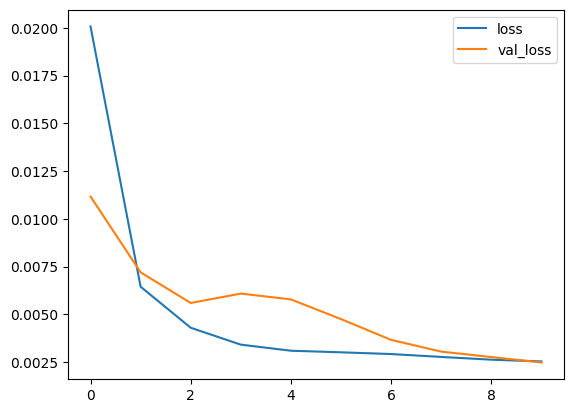

In [142]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

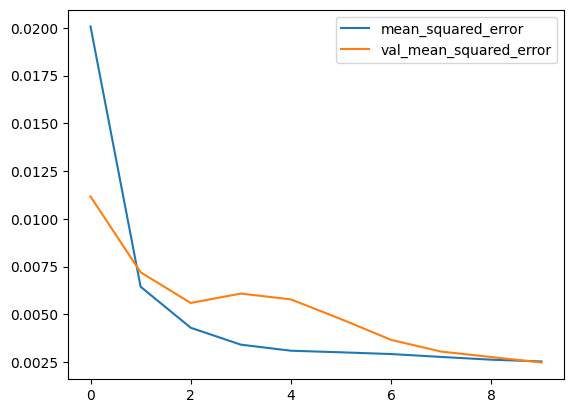

In [143]:
plt.plot(history.history['mean_squared_error'], label='mean_squared_error')
plt.plot(history.history['val_mean_squared_error'], label='val_mean_squared_error')
plt.legend()
plt.show()

In [144]:
preds = model.predict(X_test)

55/55 [==============================] - 0s 3ms/step


In [145]:
preds = scaler.inverse_transform(preds)

In [146]:
mean_squared_error(preds, Y_test), mean_absolute_error(preds, Y_test), r2_score(preds, Y_test)

(4325477.647854964, 1749.1167737773246, 0.8712116936461806)

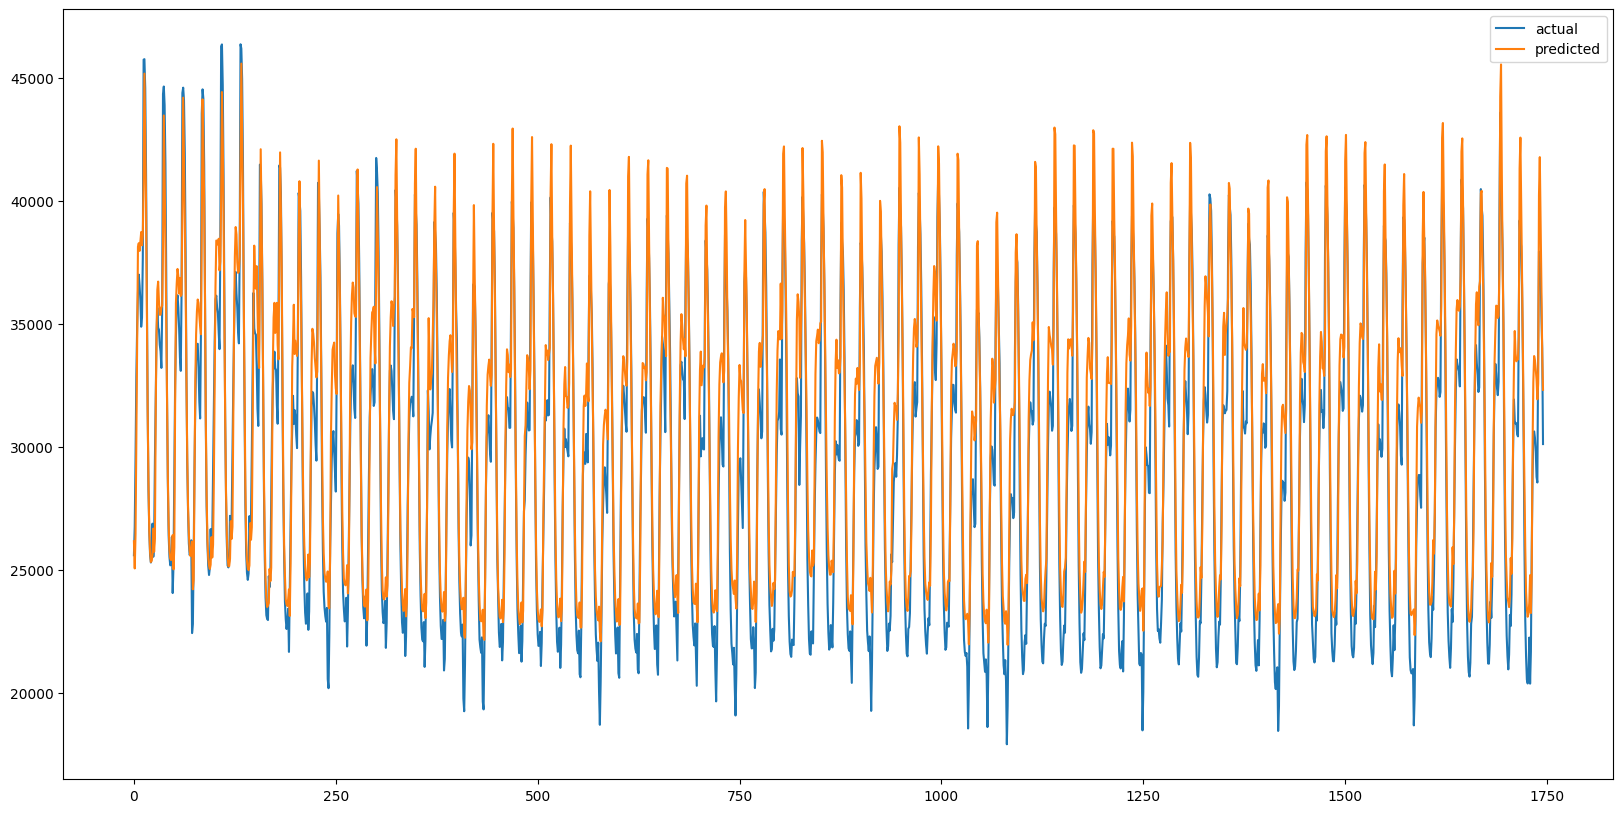

In [147]:
plt.figure(figsize=(20, 10))
plt.plot(Y_test.values, label='actual')
plt.plot(preds, label='predicted')
plt.legend()
plt.show()